In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import MNIST

C:\Users\shdhk\anaconda3\envs\agent\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\shdhk\anaconda3\envs\agent\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [21]:
plt.style.use("ggplot")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CHANNELS, IMG_ROWS, IMG_COLS = 1, 28, 28
IMG_SHAPE = (CHANNELS, IMG_ROWS, IMG_COLS)
Z_DIM = 100

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * 7 * 7)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(-1, 256, 7, 7)
        output = self.model(x)
        return output
    
    
generator = Generator(z_dim=Z_DIM).to(DEVICE)
summary(generator, (Z_DIM, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
   ConvTranspose2d-2          [-1, 128, 14, 14]         295,040
       BatchNorm2d-3          [-1, 128, 14, 14]             256
         LeakyReLU-4          [-1, 128, 14, 14]               0
   ConvTranspose2d-5           [-1, 64, 14, 14]          73,792
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]             577
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 1,636,737
Trainable params: 1,636,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 6.24
Estimated Total Size (MB): 7.21
---------------------------------------

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=img_shape[0], out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Flatten(),
            nn.Linear(3 * 3 * 128, 1),
        )

    def forward(self, x):
        x = self.model(x)
        return x
    
    
discriminator = Discriminator(img_shape=IMG_SHAPE).to(DEVICE)
summary(discriminator, IMG_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
         LeakyReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]          73,856
         LeakyReLU-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                    [-1, 1]           1,153
Total params: 93,825
Trainable params: 93,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.36
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [12]:
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.002)
optimizer_g = optim.Adam(generator.parameters(), lr=0.002)
criterion = nn.BCEWithLogitsLoss()

In [16]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_cols=4, path="./Chapter04_image"):
    if not os.path.exists(path):
        os.mkdir(path)
    z = torch.randn(image_grid_rows * image_grid_cols, Z_DIM).to(DEVICE)
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z)
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = gen_imgs.detach().to(torch.device("cpu")).numpy()
    fig, axes = plt.subplots(image_grid_rows, image_grid_cols, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axes[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap="gray")
            axes[i, j].axis("off")
            cnt += 1
    plt.tight_layout()
    plt.savefig(f"{path}/img_{iteration:03d}")
    plt.close()

In [18]:
losses, iteration_checkpoints = [], []
iterations = 20000
batch_size = 128
sample_interval = 1000

download_root = "./MNIST_DATASET"
train_dataset = MNIST(download_root, train=True, download=True)
train_img = (train_dataset.data / 127.5) - 1.0
train_img = torch.unsqueeze(train_img, 1)

real = torch.ones(batch_size, 1).to(DEVICE)
fake = torch.zeros(batch_size, 1).to(DEVICE)

for iteration in range(iterations):
    idx = np.random.randint(low=0, high=train_img.shape[0], size=batch_size)
    real_imgs = train_img[idx].to(DEVICE)
    
    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    gen_imgs = generator(z)
    
    optimizer_d.zero_grad()
    d_pred_real, d_pred_fake = discriminator(real_imgs), discriminator(gen_imgs)
    d_loss_real, d_loss_fake = criterion(d_pred_real, real), criterion(d_pred_fake, fake)
    d_loss = (d_loss_real + d_loss_fake) * 0.5
    d_loss.backward()
    optimizer_d.step()
    
    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    gen_imgs = generator(z)
    
    optimizer_g.zero_grad()
    d_pred_fake = discriminator(gen_imgs)
    g_loss = criterion(d_pred_fake, real)
    g_loss.backward()
    optimizer_g.step()
    
    if (iteration + 1) % sample_interval == 0:
        losses.append([d_loss.item(), g_loss.item()])
        iteration_checkpoints.append(iteration + 1)
        print(f"{iteration + 1} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        sample_images(generator, iteration=iteration + 1)

1000 [D loss: 0.2778] [G loss: 2.0354]
2000 [D loss: 0.2393] [G loss: 3.0371]
3000 [D loss: 0.2945] [G loss: 2.8582]
4000 [D loss: 0.2815] [G loss: 2.4629]
5000 [D loss: 0.2764] [G loss: 3.1139]
6000 [D loss: 0.2297] [G loss: 2.6224]
7000 [D loss: 0.2684] [G loss: 3.0314]
8000 [D loss: 0.3487] [G loss: 2.7750]
9000 [D loss: 0.2891] [G loss: 3.0938]
10000 [D loss: 0.2202] [G loss: 2.7237]
11000 [D loss: 0.2927] [G loss: 2.9000]
12000 [D loss: 0.2549] [G loss: 2.9362]
13000 [D loss: 0.2267] [G loss: 3.0560]
14000 [D loss: 0.2310] [G loss: 2.8678]
15000 [D loss: 0.3002] [G loss: 3.4558]
16000 [D loss: 0.2462] [G loss: 3.2726]
17000 [D loss: 0.1995] [G loss: 3.2689]
18000 [D loss: 0.2313] [G loss: 3.4316]
19000 [D loss: 0.2372] [G loss: 3.1844]
20000 [D loss: 0.2584] [G loss: 3.5912]


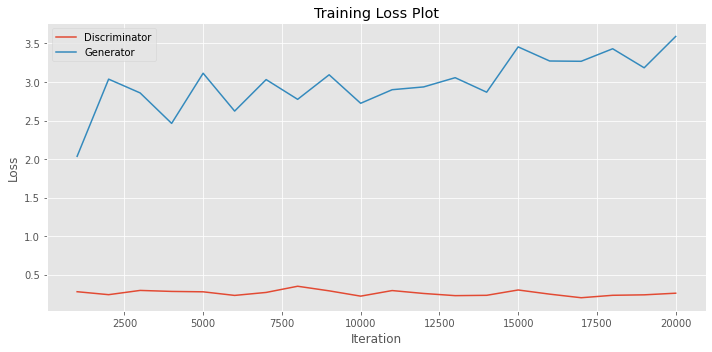

In [22]:
losses_np = np.array(losses)

plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(iteration_checkpoints, losses_np.T[0], label="Discriminator")
plt.plot(iteration_checkpoints, losses_np.T[1], label="Generator")
plt.title("Training Loss Plot")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc="best")